In [925]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer
from PIL import Image

In [926]:
import selfsupmotion.zero_shot_pose as zsp
zsp.use_cupy = False
experiment = "../output"
embeddings, info_df, train_embeddings, train_info_df = zsp.read_experiment(experiment)


In [2220]:
idx=25236
points_2d, points_3d_query = zsp.get_points(info_df, idx)
points_2d_px_query = zsp.points_2d_to_points2d_px(points_2d, 360, 480)
plane_center_query, plane_normal_query= zsp.get_plane(info_df, idx)

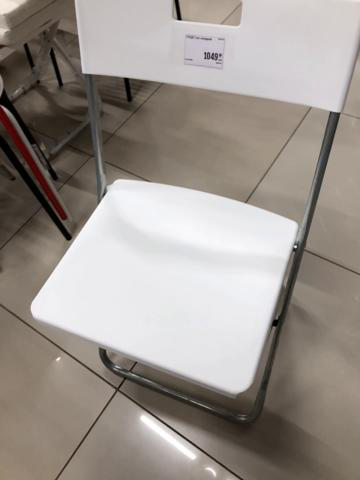

In [2221]:
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
query_im

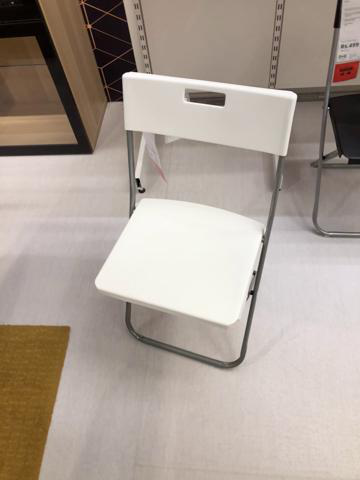

In [2222]:
match_idx, score = zsp.find_match_idx(idx, embeddings, train_embeddings,0, score=True)
res_im=Image.open(train_info_df.iloc[match_idx]["filepath_full"])
res_im

In [2228]:
train_info_df.iloc[match_idx]["filepath_full"], info_df.iloc[idx]["filepath_full"]

('/home/raphael/datasets/objectron/640x480_full/chair/batch-26_19_0.30.jpg',
 '/home/raphael/datasets/objectron/640x480_full/chair/batch-43_17_0.240.jpg')

In [2229]:
points_2d_result, points_3d_result = zsp.get_points(train_info_df, match_idx)
plane_center_result, plane_normal_result = zsp.get_plane(train_info_df, match_idx)

camera = zsp.get_camera(info_df, idx)
intrinsics = zsp.get_intrinsics(camera)
intrinsics = zsp.scale_intrinsics(intrinsics, 0.25,0.25)
intrinsics

query_bbox = zsp.get_bbox(points_2d_px_query, 360, 480)
cx = (query_bbox[0] + query_bbox[2])/2
cy = (query_bbox[1] + query_bbox[3])/2
b = (cx - intrinsics[1,2])/intrinsics[1,1]
a = (cy - intrinsics[0,2])/intrinsics[0,0]
cx, cy, a, b, points_2d_px_query[0]



(180.0,
 221.7447853088379,
 -0.034279882537203196,
 0.0006212390091671603,
 array([180.93250751, 249.41342354]))

In [2230]:
points_2d_px_result = zsp.points_2d_to_points2d_px(points_2d, 360, 480)
points_2d_px_result


array([[ 180.93250751,  249.41342354],
       [ 155.17325878,  235.29863834],
       [  85.7828486 ,  374.02107239],
       [  75.29016495,  -29.15574074],
       [-143.44387293,  179.95900154],
       [ 299.08364296,  274.71150398],
       [ 254.53245163,  443.48957062],
       [ 379.70290661,  -10.89554787],
       [ 298.20001602,  313.66968155]])

In [2231]:
result_bbox = zsp.get_bbox(points_2d_px_result, 360, 480)
cx_result = (result_bbox[0] + result_bbox[2])/2
cy_result = (result_bbox[1] + result_bbox[3])/2
cx_result, cy_result

(180.0, 221.7447853088379)

In [2232]:
points_2d, points_3d_query = zsp.get_points(info_df, idx)
points_2d_px = zsp.points_2d_to_points2d_px(points_2d, 360, 480)
camera = zsp.get_camera(info_df, idx)
intrinsics = zsp.get_intrinsics(camera)
intrinsics = zsp.scale_intrinsics(intrinsics, 0.25,0.25)
query_bbox = zsp.get_bbox(points_2d_px, 360, 480)
cx = (query_bbox[0] + query_bbox[2])/2 
cy = (query_bbox[1] + query_bbox[3])/2 

In [2233]:
query_bbox

(0, 0, 360, 443.4895706176758)

In [2234]:
result_bbox

(0, 0, 360, 443.4895706176758)

In [2235]:
result_bbox[2]-result_bbox[0], query_bbox[2]-query_bbox[0]

(360, 360)

In [2236]:
projected_center_result = points_2d_px_result[0]
adjust_x = projected_center_result[0] - cx_result
adjust_y = projected_center_result[1] - cy_result
adjust_x, adjust_y

(0.9325075149536133, 27.668638229370117)

In [2237]:
adjust_x_rel = adjust_x / (result_bbox[2]-result_bbox[0])
adjust_y_rel = adjust_y / (result_bbox[3]-result_bbox[1])
adjust_x_rel, adjust_y_rel

(0.0025902986526489258, 0.06238847554145246)

In [2238]:
adjust_x_px = adjust_x_rel * (query_bbox[2]-query_bbox[0])
adjust_y_px = adjust_y_rel * (query_bbox[3]-query_bbox[1])
adjust_x_px, adjust_y_px

(0.9325075149536133, 27.668638229370117)

In [2239]:
result_bbox[2]-result_bbox[0], query_bbox[2]-query_bbox[0]

(360, 360)

In [2240]:
cx = cx + adjust_x_px
cy = cy + adjust_y_px

In [2241]:
b = (cx - intrinsics[1,2])/intrinsics[1,1]
a = (cy - intrinsics[0,2])/intrinsics[0,0]

In [2242]:
query_center_ray = np.array([a,b,-1])

In [2243]:

def get_center_ray(info_df, idx):
    points_2d, points_3d_query = zsp.get_points(info_df, idx)
    points_2d_px = zsp.points_2d_to_points2d_px(points_2d, 360, 480)
    camera = zsp.get_camera(info_df, idx)
    intrinsics = zsp.get_intrinsics(camera)
    intrinsics = zsp.scale_intrinsics(intrinsics, 0.25,0.25)
    query_bbox = zsp.get_bbox(points_2d_px, 360, 480)
    cx = (query_bbox[0] + query_bbox[2])/2 
    cy = (query_bbox[1] + query_bbox[3])/2 
    b = (cx - intrinsics[1,2])/intrinsics[1,1]
    a = (cy - intrinsics[0,2])/intrinsics[0,0]
    return np.array([a,b,-1])
#query_center_ray = get_center_ray(info_df, idx)
#query_center_ray

In [2244]:
#result_center_ray = get_center_ray(train_info_df, match_idx)
#result_center_ray

In [2245]:
box_rotation = zsp.rotation_matrix_from_vectors(plane_normal_query, plane_normal_result)
plane_normal_query, plane_normal_result, plane_center_query, plane_center_result
points_3d_axis = np.dot(points_3d_result-points_3d_result[0],box_rotation)+points_3d_result[0]


In [2246]:

#cx, cy = points_2d_px_query[0]

z=-points_3d_query[0][2]
#az = x, bz = y
point_on_center_line = np.array([a,b,-1])
point_on_center_line

def get_dist_from_plane(plane_normal, plane_center, point):
    plane = zsp.get_plane_equation_center_normal(plane_center, plane_normal)
    a, b, c, d = plane
    X,Y,Z = point
    return abs(a*X + b*Y + c*Z + d)/np.sqrt(a**2+b**2+c**2)
obj_radius = get_dist_from_plane(plane_normal_result, plane_center_result, points_3d_result[0])
obj_radius


0.3651362846772477

In [2247]:
#obj_radius = get_dist_from_plane(plane_center_query, plane_normal_query, points_3d_query[0])
#obj_radius
obj_radius = get_dist_from_plane(plane_normal_result, plane_center_result, points_3d_axis[0])
obj_radius

0.3651362846772477

In [2248]:

def intersect_plane_with_line(plane_normal, plane_center, point1, point0=np.array([0,0,0])):
    p0 = plane_center
    n = plane_normal
    l0 = point0 #Line start.
    l = point1 #Line end
    d = np.dot((p0-l0), n)/np.dot(l,n)
    intersect = l0 + d*l
    return intersect
offset = obj_radius * plane_normal_query
#offset = np.array([0,0,0])
new_center = intersect_plane_with_line(plane_normal_query, plane_center_query+offset, point_on_center_line) 
new_center, offset, points_3d_query[0], points_3d_result[0]


(array([ 0.0254212 ,  0.00212393, -0.71326675]),
 array([-0.20191659, -0.04202797,  0.30131021]),
 array([ 0.02549016,  0.00147921, -0.72227573]),
 array([ 0.02465816,  0.02905269, -1.05004704]))

In [2249]:
old_snap = intersect_plane_with_line(plane_normal_query, plane_center_query, query_center_ray) 
new_snap = intersect_plane_with_line(plane_normal_result, plane_center_result, result_center_ray) 
old_snap, new_snap, new_snap-old_snap

(array([ 0.04081739,  0.00341027, -1.14525242]),
 array([-0.01989923,  0.07455577, -1.52777784]),
 array([-0.06071663,  0.0711455 , -0.38252542]))

In [2250]:
get_dist_from_plane(plane_normal_query, plane_center_query, new_center)
points_3d_result_centered = points_3d_axis - points_3d_axis[0] + new_center
points_3d_result_centered

array([[ 0.0254212 ,  0.00212393, -0.71326675],
       [ 0.0144284 , -0.09524349, -1.17630826],
       [ 0.3343354 , -0.23561012, -0.9814688 ],
       [-0.38885271, -0.17871431, -0.57351971],
       [-0.06894838, -0.31883683, -0.37867771],
       [ 0.11954677,  0.32308193, -1.04784837],
       [ 0.43969778,  0.18271804, -0.85301633],
       [-0.28373434,  0.23961111, -0.44505982],
       [ 0.036414  ,  0.09949133, -0.25022535]])

In [2251]:
def snap_to_plane_px(points3d, plane_normal_query, plane_center_query, plane_normal_result, plane_center_result, obj_radius=None):
    if obj_radius is None:
        obj_radius = get_dist_from_plane(plane_normal_result, plane_center_result, points3d[0])
    offset = obj_radius * plane_normal_query
    old_snap = intersect_plane_with_line(plane_normal_query, plane_center_query+offset, query_center_ray) 
    new_snap = intersect_plane_with_line(plane_normal_result, plane_center_result+offset, result_center_ray) 
    #new_center = intersect_plane_with_line(plane_normal_query, plane_center_query+offset, point_on_center_line) 
    snapped = points3d - old_snap + new_snap
    return snapped
snap_to_plane_px(points_3d_axis, plane_normal_query, plane_center_query, plane_normal_result, plane_center_result)

array([[-0.01476624,  0.0793941 , -1.41188657],
       [-0.02575904, -0.01797332, -1.87492809],
       [ 0.29414796, -0.15833995, -1.68008863],
       [-0.42904015, -0.10144413, -1.27213953],
       [-0.10913582, -0.24156666, -1.07729753],
       [ 0.07935932,  0.4003521 , -1.7464682 ],
       [ 0.39951034,  0.25998821, -1.55163615],
       [-0.32392178,  0.31688128, -1.14367964],
       [-0.00377345,  0.1767615 , -0.94884518]])

In [2252]:
#points_3d_result_centered = points_3d_axis + new_snap-old_snap

In [2253]:
def snap_to_plane(points3d, plane_normal, plane_center, obj_radius=None):
    if obj_radius is None:
        obj_radius = get_dist_from_plane(plane_normal_result, plane_center_result, points3d[0])
    offset = obj_radius * plane_normal_query
    new_center = intersect_plane_with_line(plane_normal_query, plane_center_query+offset, point_on_center_line) 
    snapped = points3d - points3d[0] + new_center
    return snapped
points_3d_result_centered_px = snap_to_plane(points_3d_axis, plane_normal_query+offset, plane_center_query+offset)
points_3d_result_centered_px

array([[ 0.0254212 ,  0.00212393, -0.71326675],
       [ 0.0144284 , -0.09524349, -1.17630826],
       [ 0.3343354 , -0.23561012, -0.9814688 ],
       [-0.38885271, -0.17871431, -0.57351971],
       [-0.06894838, -0.31883683, -0.37867771],
       [ 0.11954677,  0.32308193, -1.04784837],
       [ 0.43969778,  0.18271804, -0.85301633],
       [-0.28373434,  0.23961111, -0.44505982],
       [ 0.036414  ,  0.09949133, -0.25022535]])

In [2254]:
import pandas as pd
def build_df(points_3d, name="default"):
    df = pd.DataFrame(points_3d).rename(columns={0:"x", 1:"y", 2:"z"})
    df["name"]=name
    df = df.append(pd.Series([0,0,0,"gluk"], index=df.columns ), ignore_index=True)
    return df

In [2255]:
points3d_df = build_df(points_3d_query, "query")
#points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
points3d_df = points3d_df.append(build_df(points_3d_result_centered, "result_centered"))
points3d_df = points3d_df.append(build_df(points_3d_result_centered_px, "transformed"))
#points3d_df

In [2256]:
plane_center_query,plane_normal_query

(array([ 0.22331572,  0.04265562, -1.01748097]),
 array([-0.55298966, -0.11510214,  0.82519931]))

In [2257]:
points_3d_query

array([[ 2.54901648e-02,  1.47920847e-03, -7.22275734e-01],
       [-3.95655632e-04, -7.45654106e-02, -1.18374670e+00],
       [ 3.41667891e-01, -2.32571691e-01, -9.76559520e-01],
       [-3.96046638e-01, -1.56918228e-01, -5.93336284e-01],
       [-5.39830923e-02, -3.14924449e-01, -3.86149049e-01],
       [ 1.04963422e-01,  3.17882955e-01, -1.05840230e+00],
       [ 4.47026730e-01,  1.59876645e-01, -8.51215243e-01],
       [-2.90687561e-01,  2.35530078e-01, -4.67991829e-01],
       [ 5.13759851e-02,  7.75238276e-02, -2.60804772e-01]])

In [2258]:
import plotly.express as px
import plotly.express as px
#df = points3d_result
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()


In [2259]:
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result_centered))

0.8659977692096327

In [2260]:
#zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points_3d_result))

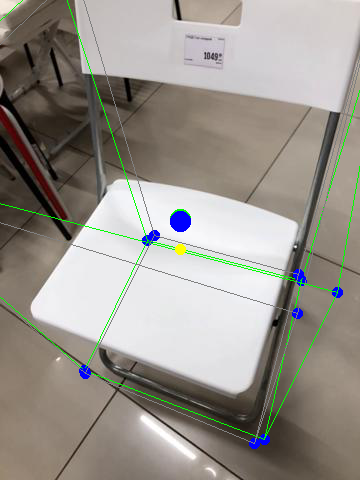

In [2261]:
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
points2d_px_result = zsp.project_3d_to_2d(points_3d_result_centered, intrinsics)
points2d_px_query = zsp.project_3d_to_2d(points_3d_query, intrinsics)
zsp.draw_bbox(query_im,points2d_px_result)
zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128), pixel_center_color=(0,0,255),object_center_color=(255,255,0))

In [2262]:
result_bbox = zsp.get_bbox(points2d_px_result, query_im.width, query_im.height)
query_bbox = zsp.get_bbox(points2d_px_query, query_im.width, query_im.height)

In [2263]:
def get_bbox_area(bbox):
    dx = bbox[2]-bbox[0]
    dy = bbox[3]-bbox[1]
    return np.sqrt(dx**2+dy**2)
scale = get_bbox_area(query_bbox) / get_bbox_area(result_bbox)
scale

1.0052367570965126

In [2264]:
def get_scale_factor(points_3d_query, points3d_scaled):
    points2d_px_result = zsp.project_3d_to_2d(points3d_scaled, intrinsics)
    points2d_px_query = zsp.project_3d_to_2d(points_3d_query, intrinsics)
    result_bbox = zsp.get_bbox(points2d_px_result, query_im.width, query_im.height)
    query_bbox = zsp.get_bbox(points2d_px_query, query_im.width, query_im.height)
    scale = get_bbox_area(query_bbox) / get_bbox_area(result_bbox)
    return scale

In [2265]:
def get_smooth_scale_factor(points_3d_query, points3d_scaled, alpha):
    factor = get_scale_factor(points_3d_query, points3d_scaled)    
    return (alpha+factor-1)/alpha

In [2266]:
scale = get_smooth_scale_factor(points_3d_query, points_3d_result_centered, 2)
scale

1.0026183785482563

In [2267]:
def scale_3d_bbox(bbox, factor):
    assert factor>0
    #factor_a = (1+factor)/2
    #factor_b = (1+factor)/2
    center = bbox[0]
    bbox = (bbox-center)*factor + center #/factor_b
    return bbox

In [2268]:
points3d_scaled = snap_to_plane(scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, obj_radius = obj_radius*scale)
#points3d_scaled = snap_to_plane(scale_3d_bbox(points_3d_result, scale), plane_normal_query, plane_center_query)
#points3d_scaled = scale_3d_bbox(points_3d_result_centered, scale)
#points3d_scaled = snap_to_plane_px(scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, plane_normal_result, plane_center_result, obj_radius = obj_radius*scale)

points3d_scaled

array([[ 0.02538089,  0.00212056, -0.71213564],
       [ 0.0143593 , -0.0955018 , -1.17638958],
       [ 0.33510395, -0.23623597, -0.98103995],
       [-0.38997774, -0.17919118, -0.57202269],
       [-0.06923579, -0.3196806 , -0.37667052],
       [ 0.11975291,  0.32391895, -1.04759333],
       [ 0.4407422 ,  0.18318753, -0.85225114],
       [-0.28458414,  0.24022957, -0.44322645],
       [ 0.03640247,  0.09974291, -0.24788183]])

In [2269]:
#points3d_scaled, points_3d_result, snap_to_plane(points_3d_axis, plane_normal_query, plane_center_query)

In [2270]:
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))

0.863860452177625

In [2271]:

get_scale_factor(points_3d_query, points3d_scaled)

1.0043227363923268

In [2272]:

get_smooth_scale_factor(points_3d_query, points3d_scaled, 3)

1.0014409121307757

In [2273]:
scale = get_smooth_scale_factor(points_3d_query, points3d_scaled, 2)
for i in range(0,3):
    obj_radius = get_dist_from_plane(plane_normal_query, plane_center_query, points3d_scaled[0])
    points3d_scaled = snap_to_plane(scale_3d_bbox(points3d_scaled, scale), plane_normal_query, plane_center_query, obj_radius = obj_radius*scale)
#    points3d_scaled = snap_to_plane_px(scale_3d_bbox(points_3d_result_centered, scale), plane_normal_query, plane_center_query, plane_normal_result, plane_center_result, obj_radius = obj_radius*scale)
    scale = get_smooth_scale_factor(points_3d_query, points3d_scaled, 2)
    print(i, obj_radius, scale, zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled)))
zsp.get_iou_between_bbox(np.array(points_3d_query), np.array(points3d_scaled))

0 0.3660923430469878 1.0017829355015058 0.8620829892521007
1 0.36688359673449716 1.001469949985838 0.8606078462827629
2 0.36753771985255035 1.0012113537660503 0.8593856624418994


0.8593856624418994

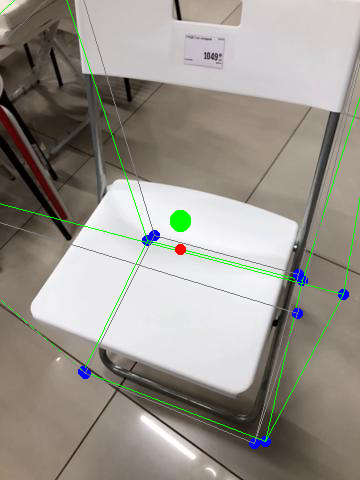

In [2274]:
query_im=Image.open(info_df.iloc[idx]["filepath_full"])
points2d_px_result = zsp.project_3d_to_2d(points3d_scaled, intrinsics)
points2d_px_query = zsp.project_3d_to_2d(points_3d_query, intrinsics)
zsp.draw_bbox(query_im,points2d_px_result)
zsp.draw_bbox(query_im,points2d_px_query, line_color=(128,128,128))

In [2275]:
points3d_df = build_df(points_3d_query, "query")
#points3d_df = points3d_df.append(build_df(points_3d_result, "result"))
points3d_df = points3d_df.append(build_df(points3d_scaled, "points3d_scaled"))
fig = px.scatter_3d(points3d_df, x="x", y="y", z="z", color="name")
fig.show()